Autor: Rodrigo Stuckert. Data: 2020-06-23

# Análise da Covid-19 no Distrito Federal

Este código foi feito para analisar os casos da covid-19 no Distrito Federal (DF).

Cabe salientar que, a partir do dia 2020-07-09, houve uma alteração na disposição dos dados. Removeu-se o número de identificação de cada pessoa (**id**); adicionou-se uma nova variável, **dataPrimeirosintomas**, indicando o início dos sintomas; e, por fim, substitui-se a variável **Estado de Saúde** por uma **Óbito**, indicando se a pessoa faleceu até aquele dia, ou não.

Link para a página de extração dos dados: https://covid19.ssp.df.gov.br/extensions/covid19/covid19.html#/

Dados do dia 2020-07-08 12:00

## Extração dos dados

In [1]:
# Pacotes:
library(dplyr)
library(lubridate) # Manipular datas
library(ggplot2)
library(esquisse) # Interface pro ggplot2

Warning message:
"package 'dplyr' was built under R version 3.6.2"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'lubridate' was built under R version 3.6.2"
Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Warning message:
"package 'ggplot2' was built under R version 3.6.2"Warning message:
"package 'esquisse' was built under R version 3.6.3"

In [2]:
# Puxa o arquivo e importa os dados
arquivo <- "datasets/dados-abertos.csv"
#link <- "https://covid19.ssp.df.gov.br/resources/dados/dados-abertos.csv"
df <- data.table::fread(arquivo, encoding = "UTF-8", 
                        col.names = c("id", "Data", "DataCadastro", "Sexo",
                                      "FaixaEtaria", "RA", "UF", "EstadoSaude",
                                      "Pneumopatia", "Nefropatia", "DHematologica",
                                      "DistMetabolico", "Imunopressao", "Obesidade",
                                      "Outros", "Cardiovasculopatia"),
                        colClasses = list(factor= c(4, 6, 7)) # Colunas Sexo, RA e UF como factors
                        )

## Tratamento dos dados

Primeiro, precisamos alterar o nome dos inputs da variável FaixaEtaria para que possamos torná-la uma factor corretamente.

In [3]:
# Corrige os nomes das faixas etárias e torna a variável factor.
df <- df %>%
  mutate(FaixaEtaria = ifelse(FaixaEtaria == "<= 19 anos", "0 a 19 anos", FaixaEtaria),
         FaixaEtaria = ifelse(FaixaEtaria == ">= 60 anos", "60+ anos", FaixaEtaria),
         FaixaEtaria = as.factor(FaixaEtaria))

# Pega a data de extração dos dados
extraction_date <- df$Data[1] %>%
  as.Date(format = '%d/%m/%Y')

Agora, verificaremos a importação do arquivo.

In [4]:
# Verifica a importação do arquivo
str(df) # Estrutura
head(df) # Início
#tail(df) # Fim

'data.frame':	62867 obs. of  16 variables:
 $ id                : int  1 2 3 6 8 10 12 13 14 15 ...
 $ Data              : chr  "08/07/2020" "08/07/2020" "08/07/2020" "08/07/2020" ...
 $ DataCadastro      : chr  "18/03/2020" "18/03/2020" "18/03/2020" "18/03/2020" ...
 $ Sexo              : Factor w/ 2 levels "Feminino","Masculino": 2 2 2 2 1 1 1 1 2 1 ...
 $ FaixaEtaria       : Factor w/ 6 levels "0 a 19 anos",..: 5 5 4 6 2 3 3 5 1 3 ...
 $ RA                : Factor w/ 37 levels "Arniqueira","Brazlândia",..: 20 13 13 37 20 20 11 13 32 13 ...
 $ UF                : Factor w/ 28 levels "","ACRE","ALAGOAS",..: 8 8 8 8 8 8 8 8 8 8 ...
 $ EstadoSaude       : chr  "Recuperado" "Recuperado" "Recuperado" "Recuperado" ...
 $ Pneumopatia       : chr  "" "Sim" "" "Não" ...
 $ Nefropatia        : chr  "" "Não" "" "Não" ...
 $ DHematologica     : chr  "" "Não" "" "Não" ...
 $ DistMetabolico    : chr  "" "Sim" "" "Sim" ...
 $ Imunopressao      : chr  "" "Não" "" "Não" ...
 $ Obesidade         : chr

id,Data,DataCadastro,Sexo,FaixaEtaria,RA,UF,EstadoSaude,Pneumopatia,Nefropatia,DHematologica,DistMetabolico,Imunopressao,Obesidade,Outros,Cardiovasculopatia
1,08/07/2020,18/03/2020,Masculino,50 a 59 anos,Plano Piloto,DISTRITO FEDERAL,Recuperado,,,,,,,,
2,08/07/2020,18/03/2020,Masculino,50 a 59 anos,Lago Sul,DISTRITO FEDERAL,Recuperado,Sim,Não,Não,Sim,Não,Não,Não,Não
3,08/07/2020,18/03/2020,Masculino,40 a 49 anos,Lago Sul,DISTRITO FEDERAL,Recuperado,,,,,,,,
6,08/07/2020,18/03/2020,Masculino,60+ anos,Águas Claras,DISTRITO FEDERAL,Recuperado,Não,Não,Não,Sim,Não,Não,Não,Sim
8,08/07/2020,18/03/2020,Feminino,20 a 29 anos,Plano Piloto,DISTRITO FEDERAL,Recuperado,,,,,,,,
10,08/07/2020,16/03/2020,Feminino,30 a 39 anos,Plano Piloto,DISTRITO FEDERAL,Recuperado,,,,,,,,


#### Agora, faremos o tratamento dos dados propriamente dito.

Devemos ter cautela especial quanto à variável Comorbidade. Inicialmente, pessoas com alguma comorbidade recebiam "Sim" para aquelas que apresentassem, e "Não" para todas as demais, enquanto que quem não apresentasse nenhuma aparecia como NA para todas. Após determinada data, o GDF passou a apenas a categorizar aqueles que apresentassem alguma comorbidade.


In [5]:
# Bota os valores das comorbidades como binários (Apresenta = 1, não apresenta / NA = 0)
df <- df %>% 
  mutate(Pneumopatia = ifelse(Pneumopatia == "Sim", 1, 0), 
         Nefropatia = ifelse(Nefropatia == "Sim", 1, 0),
         DHematologica = ifelse(DHematologica == "Sim", 1, 0),
         DistMetabolico = ifelse(DistMetabolico == "Sim", 1, 0),
         Imunopressao = ifelse(Imunopressao == "Sim", 1, 0),
         Obesidade = ifelse(Obesidade == "Sim", 1, 0),
         Outros = ifelse(Outros == "Sim", 1, 0),
         Cardiovasculopatia = ifelse(Cardiovasculopatia == "Sim", 1, 0)
  )


# Remove a coluna com a data de extração, corrige a coluna das datas de entrada,
# e cria as variáveis "Tem comorbidade?" e "Estado ativo?"
df <- df %>%
  
  select(-c("Data")) %>%
  
  mutate(DataCadastro = as.Date(DataCadastro, format = '%d/%m/%Y'),
         Comorbidade = case_when(Pneumopatia + Nefropatia + DHematologica + DistMetabolico + Imunopressao + Outros + Cardiovasculopatia > 0 ~ 1, TRUE ~ 0),
         Status = ifelse(EstadoSaude %in% c("Leve", "Moderado", "Grave", "Não Informado"), 
                         "Ativo", EstadoSaude)) # Cria a variável "Status", que mostra se a pessoa está recuperada,se foi a óbito, ou se é um caso ativo.

# Verificando novamente
class(df$DataCadastro)
head(df$DataCadastro)
table(df$Status) # Variável de estado do paciente

[1] "Date"

[1] "2020-03-18" "2020-03-18" "2020-03-18" "2020-03-18" "2020-03-18"
[6] "2020-03-16"


     Ativo      Óbito Recuperado 
     11198        789      50880 

In [6]:
df <- df %>%
  mutate(Comorbidade = as.factor(df$Comorbidade))

## Análise exploratória

Agora, seguiremos com a análise exploratória dos dados. Primeiro, geraremos agregações dos dados por categorias de interesse; em seguida, prosseguiremos com a elaboração de gráficos.

### Estatísticas agregadas

Gerando estatísticas agregadas pelas Regiões Administrativas (RA's) do Distrito Federal, por gênero e faixa etária:

In [7]:
# Gera estatísticas agrupadas...
# ... por Região Administrativa do Distrito Federal (RA)
grouped_by_RA <- df %>% 
  group_by(RA) %>%
  summarise(casos = n(),
            casos_ativos = sum(Status == "Ativo"),
            obitos = sum(Status == "Óbito"),
            mortalidade = obitos / casos,
            pct_comorbidade = sum(Comorbidade == 1) / casos,
            pct_mulheres = sum(Sexo == "Feminino")/casos,
            pct_homens = 1 - pct_mulheres
            )

# ... por sexo da pessoa
grouped_by_Sexo <- df %>% 
  group_by(Sexo) %>%
  summarise(casos = n(),
            casos_ativos = sum(Status == "Ativo"),
            obitos = sum(Status == "Óbito"),
            mortalidade = obitos / casos,
            pct_comorbidade = sum(Comorbidade == 1) / casos
            )

# ...por faixa etária
grouped_by_FxEtaria <- df %>% 
  group_by(FaixaEtaria) %>%
  summarise(casos = n(),
            casos_ativos = sum(Status == "Ativo"),
            obitos = sum(Status == "Óbito"),
            pct_obitos = sum(Status == "Óbito") / sum(df$Status == "Óbito"),
            mortalidade = obitos / casos,
            pct_comorbidade = sum(Comorbidade == 1) / casos,
            pct_mulheres = sum(Sexo == "Feminino")/casos,
            pct_homens = 1 - pct_mulheres
            )

# ...por data
grouped_by_Data <- df %>% 
  group_by(DataCadastro) %>%
  summarise(casos = n(),
            casos_ativos = sum(Status == "Ativo"),
            obitos = sum(Status == "Óbito"),
            pct_obitos = sum(Status == "Óbito") / sum(df$Status == "Óbito"),
            mortalidade = obitos / casos,
            pct_comorbidade = sum(Comorbidade == 1) / casos,
            pct_mulheres = sum(Sexo == "Feminino")/casos,
            pct_homens = 1 - pct_mulheres
            )

### Visualização gráfica

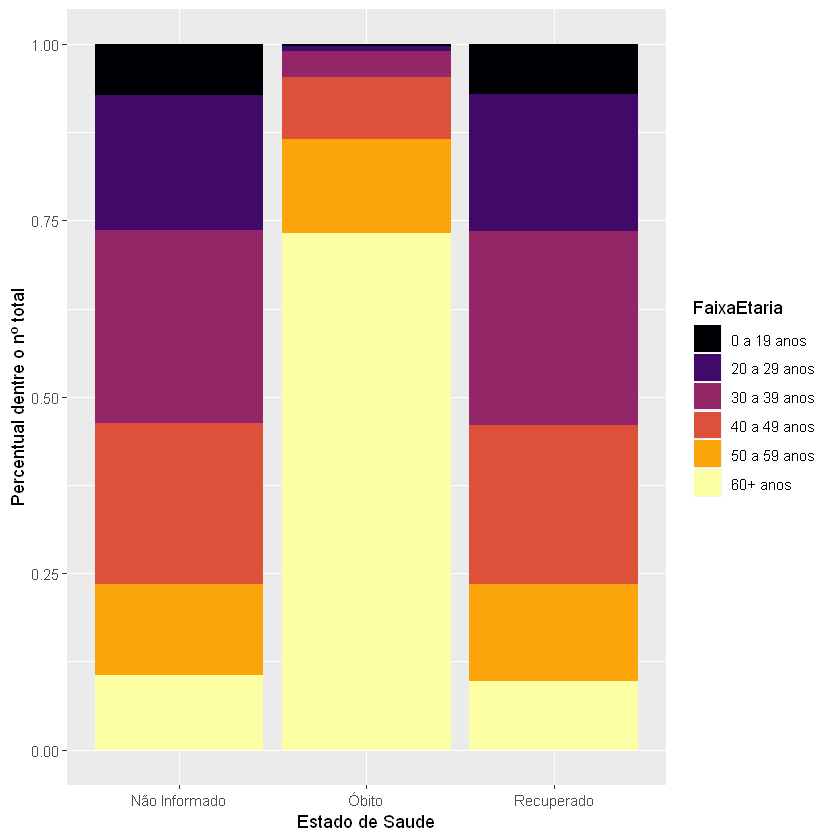

In [8]:
# Visualização gráfica.
#esquisser(data = df)

df %>%
 filter(!(UF %in% "")) %>%
 ggplot() +
 aes(x = EstadoSaude, fill = FaixaEtaria) +
 geom_bar(position = "fill") +
 scale_fill_viridis_d(option = "inferno") +
 labs(x = "Estado de Saude", y = "Percentual dentre o nº total")

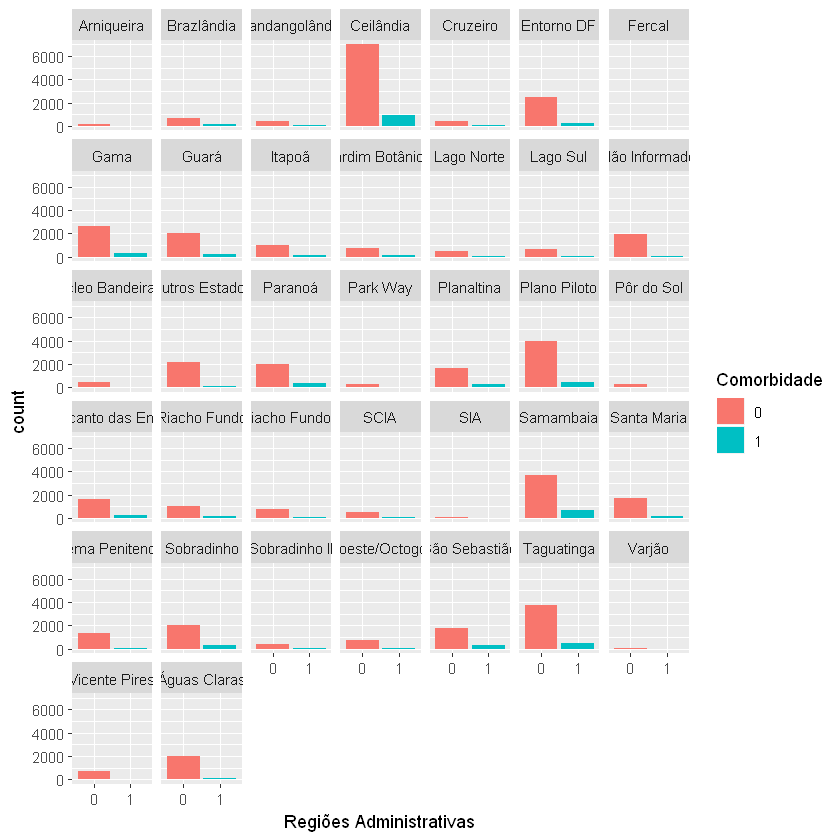

In [12]:
df %>%
  filter(!(UF %in% "")) %>%
  ggplot() +
  aes(x = Comorbidade, fill = Comorbidade) +
  geom_bar() +
  scale_fill_hue() +
  labs(x = "Regiões Administrativas") +
  facet_wrap(vars(RA))

In [10]:
library(tidyquant) # Para médias móveis

Warning message:
"package 'tidyquant' was built under R version 3.6.3"Loading required package: PerformanceAnalytics
Warning message:
"package 'PerformanceAnalytics' was built under R version 3.6.3"Loading required package: xts
Warning message:
"package 'xts' was built under R version 3.6.2"Loading required package: zoo
Warning message:
"package 'zoo' was built under R version 3.6.2"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'xts'

The following objects are masked from 'package:dplyr':

    first, last


Attaching package: 'PerformanceAnalytics'

The following object is masked from 'package:graphics':

    legend

Loading required package: quantmod
Loading required package: TTR
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Version 0.4-0 included new data defaults. See ?getSymbols.
== Need to Learn tidyquant? =======================================

Warning message:
"Removed 1 rows containing missing values (position_stack)."

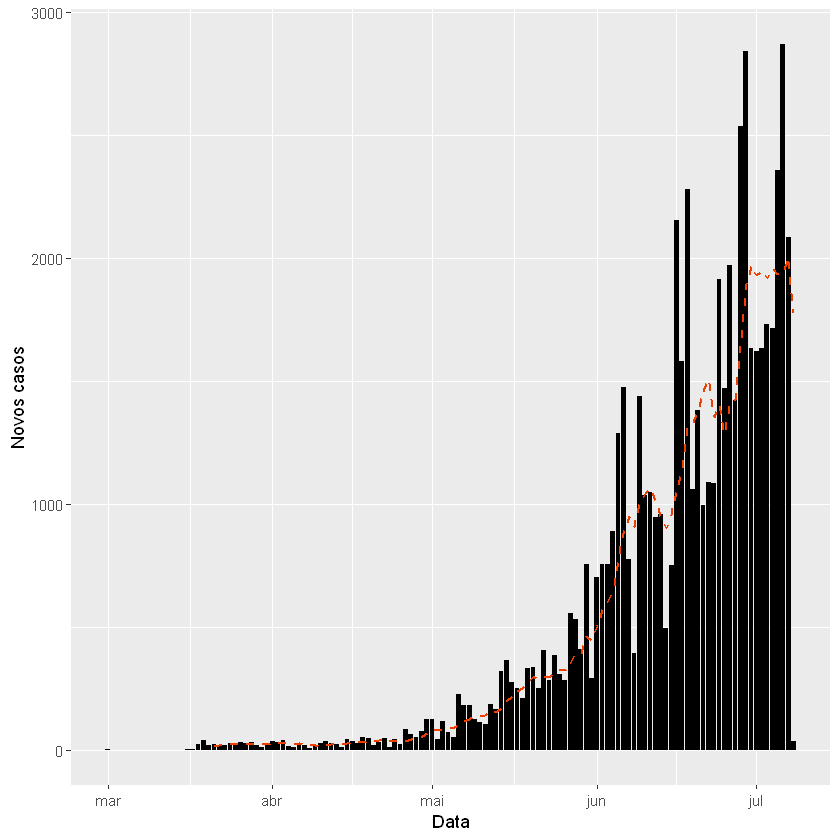

In [14]:
# Novos casos, com média móvel para os últimos 7 dias
grouped_by_Data %>%
  #filter(!(UF %in% "")) %>%
  ggplot(aes(x = DataCadastro, y = casos)) +
  #geom_line() +
  geom_bar(stat = "identity", fill = "black") +
  geom_ma(ma_fun = SMA, n = 7, color = "orangered2", size = 0.8, linetype = "dashed") +  
  labs(x = "Data", y = "Novos casos")